In [1]:
import numpy as np
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

In [12]:
def getKey(item):
    return item[1]

#compute the distance between the neighboors of x1 and return a list of the k neghboors
#where k is the complexity
def k_neighbours(x,x1_index,p_or_q='p',perplexity=5,g_kernel=1):
    x1=x[x1_index]
    list_k_neighbours=[]
    for i in range(x.shape[0]):
        if i!=x1_index:
            xi=x[i]
            if p_or_q=='p':
                distance=np.exp(-np.linalg.norm(x1-xi)**2/(2*g_kernel**2))
            else:
                distance=(1+np.linalg.norm(x1-xi)**2)**-1
            list_k_neighbours.append([i,distance])
    
    list_k_neighbours=sorted(list_k_neighbours,key=getKey)
    return list_k_neighbours[:perplexity]

#compute the similarity pij between two xi,xj in the original space
#divide the distance between xi,xj by the sum of the distances of the k_neightbours where k is the complexity
def compute_pij(x,x1_index,x2_index,g_kernel=1,perplexity=5):
    x1=x[x1_index]
    x2=x[x2_index]
    # num=(1+np.linalg.norm(x1-x2)**2)**(-1)/(2*g_kernel**2))
    num=np.exp(-np.linalg.norm(x1-x2)**2)/(2*g_kernel**2)
    denom=0
    list_k_neighbours=k_neighbours(x,x1_index,'p',perplexity=perplexity,g_kernel=g_kernel)
    for i in list_k_neighbours:
        denom+=i[1]
    return num/denom

#compute the table p of the xij in the original space
def compute_p(x,g_kernel=1,perplexity=5):
    table=np.zeros((x.shape[0],x.shape[0]))
    for i in range(x.shape[0]):
        for j in range(x.shape[0]):
            if i!=j:
                pij=compute_pij(x,i,j,g_kernel=1,perplexity=5)
                pji=compute_pij(x,j,i,g_kernel=1,perplexity=5)
                table[i,j]=(pij+pji)/(2*x.shape[0])
                # table[i,j]=pij
    return table

#compute the similarity qij between two yi,yj in the new space
#divide the distance between yi,yj by the sum of the distances of the k_neightbours where k is the complexity
def compute_qij(y,y1_index,y2_index,perplexity=5,g_kernel=1):
    y1=y[y1_index]
    y2=y[y2_index]
    num=(1+np.linalg.norm(y1-y2)**2)**(-1)
    denom=0
    for i in k_neighbours(y,y1_index,'q',perplexity,g_kernel):
        denom+=i[1]
    return num/denom

#compute the table q of the yij in the new space
def compute_q(y,perplexity=5,g_kernel=1):
    table=np.zeros((y.shape[0],y.shape[0]))
    for i in range(y.shape[0]):
        for j in range(y.shape[0]):
            if i!=j:
                qij=compute_qij(y,i,j,perplexity=perplexity,g_kernel=g_kernel)
                table[i,j]=qij
    return table

#compute the erros between the 2 distributions using the KL-divergence
def kl_divergence(p,q):
    total=0
    for i in range(p.shape[0]):
        for j in range(q.shape[0]):
            if q[i,j]!=0 and p[i,j]!=0:
                total+=p[i,j]*np.log(p[i,j]/q[i,j])
    return total

#apply gradient descent to lower the KL-divergence
#added momentum increase the speed
def gradient_descent(p,q,y,momentum=0.99,epochs=2000,lr=200,perplexity=5):
    history=np.zeros((p.shape[0],2,y.shape[1]))
    for iter in range(epochs):
        for i in range(y.shape[0]):
            sum_value=0
            for j in range(y.shape[0]):
                sum_value+=((y[i]-y[j])*(p[i,j]-q[i,j])*(1+np.linalg.norm(y[i]-y[j]**2))**-1)
            y[i]-=4*lr*sum_value+momentum*(history[i,1]-history[i,0])
            history[i,0]=history[i,1]
            history[i,1]=y[i]
        if iter%100==0:
            q=compute_q(y)
            print(kl_divergence(p,q)) 
    y-=np.mean(y)
    y/=np.std(y)
    return y

def my_tsne(X,tsne_seed=42,momentum=0.99,epochs=2000,lr=200,perplexity=5,g_kernel=1):
    np.random.seed(tsne_seed)
    table_p = compute_p(X)
    #Probably not the right way to initialize the new space y
    y=X.dot(np.random.rand(X.shape[1],2))
    y-=np.mean(y)
    y/=np.std(y)
    table_q=compute_q(y,perplexity=perplexity,g_kernel=g_kernel)
    y=gradient_descent(table_p,table_q,y,momentum,epochs,lr,perplexity)
    return(y)

In [13]:
np.random.seed(42)
x=np.random.rand(10,3)
x=np.tile(x,(2,1))
x
x[:10]*=0.1
# color=['blue']*10+['red']*10

<Axes: xlabel='x', ylabel='y'>

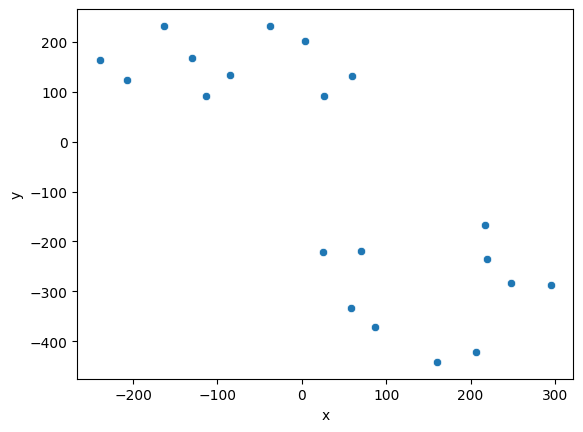

In [20]:
from sklearn.manifold import TSNE
import pandas as pd

x_skl_tsne =  pd.DataFrame(TSNE(n_components=2, learning_rate=200, init='random', perplexity=5,n_iter=2000).fit_transform(x),columns=['x','y'])
sns.scatterplot(x_skl_tsne,x='x',y='y')

-11.61469832460545
-12.890451720286345
-9.86962820080275
-9.428321156391759
-9.412331054278157
-9.408584036996
-9.410251836474881
-9.413926071558425
-9.418213092691415
-9.423207749488983
-9.430655727263208
-9.438298745269094
-9.447618208483355
-9.457891532194218
-9.469704248322097
-9.48271749079207
-9.49527236969582
-9.507416464355243
-9.520073767757905
-9.533553631630967


<Axes: xlabel='x', ylabel='y'>

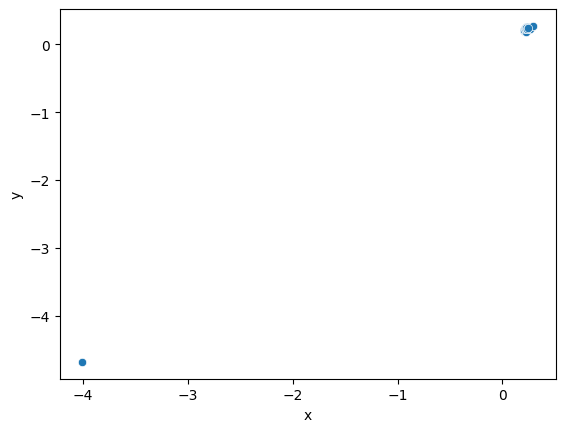

In [18]:
x_skl_tsne =  pd.DataFrame(my_tsne(x,momentum=0.88),columns=['x','y'])
sns.scatterplot(x_skl_tsne,x='x',y='y')

In [16]:
x_skl_tsne

,x,y
0,-19.922964,-53.250938
1,-82.274712,-37.380875
2,-29.761778,-66.176949
3,-102.948990,-69.495026
4,-85.071808,-21.746941
5,-64.563194,-65.538734
6,-81.840096,-67.737206
7,-63.455162,-81.300018
8,-42.584000,-34.789867
9,-56.940296,-27.754890


In [14]:
my_tsne(x)

-11.61469832460545
-12.870116388386228
-9.841768417712656
-9.41934351480321
-9.403314704737639
-9.396837813437342
-9.394859789677382
-9.397460734902943
-9.402547210665084
-9.407927743102306
-9.414836764863937
-9.422955672619073
-9.430900680554334
-9.440194776631712
-9.449833516988713
-9.461623725790298
-9.47487712017549
-9.487674365459577
-9.500725023248853
-9.514759393583548


array([[ 0.23000431,  0.21753364],
       [ 0.20243971,  0.20497145],
       [ 0.22358346,  0.20352869],
       [ 0.20807654,  0.20991246],
       [ 0.20983065,  0.21161224],
       [ 0.2168819 ,  0.19490583],
       [ 0.21331369,  0.20970091],
       [-4.04503969, -4.65062046],
       [ 0.22166748,  0.18902611],
       [ 0.22188483,  0.22276263],
       [ 0.26480666,  0.25769877],
       [ 0.22083697,  0.24236789],
       [ 0.2628389 ,  0.23385939],
       [ 0.22272685,  0.26139329],
       [ 0.23232614,  0.26373637],
       [ 0.2332042 ,  0.22287723],
       [ 0.22134149,  0.23924769],
       [ 0.23038799,  0.22642982],
       [ 0.29296547,  0.27181056],
       [ 0.24158396,  0.24158393]])

In [8]:
def main():
    #I choose a dataset with two well separated part
    x=np.random.rand(10,3)
    x=np.tile(x,(2,1))
    x[:10]*=0.1
    color=['blue']*10+['red']*10

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x[:,0],x[:,1],x[:,2],color=color)
    plt.show()

    table_p=compute_p(x)

    #Probably not the right way to initialize the new space y
    y=x.dot(np.random.rand(x.shape[1],2))
    y-=np.mean(y)
    y/=np.std(y)
    table_q=compute_q(y)
    y=gradient_descent(table_p,table_q,y)

    plt.scatter(y[:,0],y[:,1],color=color)
    plt.show()

main()

NameError: name 'compute_p' is not defined

In [ ]:



# all the formulas are from https://cs.nyu.edu/~roweis/papers/sne_final.pdf
# and http://www.cs.toronto.edu/~hinton/absps/tsne.pdf
PERPLEXITY=5
g_kernel=1
EPOCHS=2000
LR=200
MOMENTUM=0.99

def getKey(item):
    return item[1]

#compute the distance between the neighboors of x1 and return a list of the k neghboors
#where k is the complexity
def k_neighbours(x,x1_index,p_or_q='p'):
    x1=x[x1_index]
    list_k_neighbours=[]
    for i in range(x.shape[0]):
        if i!=x1_index:
            xi=x[i]
            if p_or_q=='p':
                distance=np.exp(-np.linalg.norm(x1-xi)**2/(2*g_kernel**2))
            else:
                distance=(1+np.linalg.norm(x1-xi)**2)**-1
            list_k_neighbours.append([i,distance])
    
    list_k_neighbours=sorted(list_k_neighbours,key=getKey)
    return list_k_neighbours[:PERPLEXITY]

#compute the similarity pij between two xi,xj in the original space
#divide the distance between xi,xj by the sum of the distances of the k_neightbours where k is the complexity
def compute_pij(x,x1_index,x2_index):
    x1=x[x1_index]
    x2=x[x2_index]
    # num=(1+np.linalg.norm(x1-x2)**2)**(-1)/(2*g_kernel**2))
    num=np.exp(-np.linalg.norm(x1-x2)**2)/(2*g_kernel**2)
    denom=0
    list_k_neighbours=k_neighbours(x,x1_index,'p')
    for i in list_k_neighbours:
        denom+=i[1]
    return num/denom


#compute the table p of the xij in the original space
def compute_p(x):
    table=np.zeros((x.shape[0],x.shape[0]))
    for i in range(x.shape[0]):
        for j in range(x.shape[0]):
            if i!=j:
                pij=compute_pij(x,i,j)
                pji=compute_pij(x,j,i)
                table[i,j]=(pij+pji)/(2*x.shape[0])
                # table[i,j]=pij
    return table

#compute the similarity qij between two yi,yj in the new space
#divide the distance between yi,yj by the sum of the distances of the k_neightbours where k is the complexity
def compute_qij(y,y1_index,y2_index):
    y1=y[y1_index]
    y2=y[y2_index]
    num=(1+np.linalg.norm(y1-y2)**2)**(-1)
    denom=0
    for i in k_neighbours(y,y1_index,'q'):
        denom+=i[1]
    return num/denom

#compute the table q of the yij in the new space
def compute_q(y):
    table=np.zeros((y.shape[0],y.shape[0]))
    for i in range(y.shape[0]):
        for j in range(y.shape[0]):
            if i!=j:
                qij=compute_qij(y,i,j)
                table[i,j]=qij
    return table

#compute the erros between the 2 distributions using the KL-divergence
def kl_divergence(p,q):
    total=0
    for i in range(p.shape[0]):
        for j in range(q.shape[0]):
            if q[i,j]!=0 and p[i,j]!=0:
                total+=p[i,j]*np.log(p[i,j]/q[i,j])
    return total

#apply gradient descent to lower the KL-divergence
#added momentum increase the speed
def gradient_descent(p,q,y):
    history=np.zeros((p.shape[0],2,y.shape[1]))
    for iter in range(EPOCHS):
        for i in range(y.shape[0]):
            sum_value=0
            for j in range(y.shape[0]):
                sum_value+=((y[i]-y[j])*(p[i,j]-q[i,j])*(1+np.linalg.norm(y[i]-y[j]**2))**-1)
            y[i]-=4*LR*sum_value+MOMENTUM*(history[i,1]-history[i,0])
            history[i,0]=history[i,1]
            history[i,1]=y[i]
        if iter%100==0:
            q=compute_q(y)
            print(kl_divergence(p,q)) 
    y-=np.mean(y)
    y/=np.std(y)
    return y


def main():
    #I choose a dataset with two well separated part
    x=np.random.rand(10,3)
    x=np.tile(x,(2,1))
    x[:10]*=0.1
    color=['blue']*10+['red']*10

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x[:,0],x[:,1],x[:,2],color=color)
    plt.show()

    table_p=compute_p(x)

    #Probably not the right way to initialize the new space y
    y=x.dot(np.random.rand(x.shape[1],2))
    y-=np.mean(y)
    y/=np.std(y)
    table_q=compute_q(y)
    y=gradient_descent(table_p,table_q,y)

    plt.scatter(y[:,0],y[:,1],color=color)
    plt.show()

main()